# Alternative Credit Scoring Model with Loan Amount Feature

This notebook implements an alternative credit scoring system based on non-traditional data points, including loan amount as a key feature. The model uses the Lending Club dataset as a foundation and implements feature engineering to create a scoring system aligned with the specified categories:

1. Income Stability (35%)
2. Payment Consistency (30%)
3. Asset Value (20%)
4. Behavioral Factors (15%)

## Key Features of this Notebook:
- Loan amount is incorporated as a key decision factor
- Each model is trained in a separate code cell for selective execution
- GPU acceleration for applicable models
- Focused on Logistic Regression and XGBoost models
- Inference can be run with either model for comparison
- Detailed performance metrics and loan approval recommendations

## Setup and Configuration

In [1]:
# Install required packages
!pip install numpy pandas matplotlib seaborn scikit-learn xgboost tensorflow

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, f1_score, accuracy_score
from sklearn.feature_selection import SelectFromModel
import xgboost as xgb
import pickle
import os
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

In [3]:
# Check for GPU availability
try:
    import tensorflow as tf
    print("TensorFlow version:", tf.__version__)
    print("GPU Available: ", len(tf.config.list_physical_devices('GPU')) > 0)
    print("GPU Devices: ", tf.config.list_physical_devices('GPU'))

    # Configure TensorFlow to use memory growth to avoid OOM errors
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            print("TensorFlow GPU memory growth enabled")
        except RuntimeError as e:
            print(f"TensorFlow GPU memory growth error: {e}")
except Exception as e:
    print(f"TensorFlow not available or GPU not detected: {e}")

# Check XGBoost GPU support
try:
    # Create a small test dataset
    X_test = np.random.random((10, 5))
    y_test = np.random.randint(0, 2, 10)

    # Try to create an XGBoost model with GPU
    xgb_test = xgb.XGBClassifier(tree_method='gpu_hist', gpu_id=0)
    xgb_test.fit(X_test, y_test)
    print("XGBoost GPU support available")
    XGB_GPU_AVAILABLE = True
except Exception as e:
    print(f"XGBoost GPU support not available: {e}")
    XGB_GPU_AVAILABLE = False

TensorFlow version: 2.18.0
GPU Available:  False
GPU Devices:  []
XGBoost GPU support not available: [11:32:20] /workspace/src/tree/updater_gpu_hist.cu:861: Exception in gpu_hist: [11:32:20] /workspace/src/tree/updater_gpu_hist.cu:867: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x25c1ac) [0x7b8c0e65c1ac]
  [bt] (1) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0xe2d2dd) [0x7b8c0f22d2dd]
  [bt] (2) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0xe3b814) [0x7b8c0f23b814]
  [bt] (3) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x5ad006) [0x7b8c0e9ad006]
  [bt] (4) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x5ae3d4) [0x7b8c0e9ae3d4]
  [bt] (5) /usr/local/lib/python3.11/dist-packages/xgboost/lib/libxgboost.so(+0x5f8cd8) [0x7b8c0e9f8cd8]
  [bt] (6) /usr/local/lib/python3.11/dist-p

## Data Loading and Initial Exploration

### Option 1: Download the Lending Club dataset from Kaggle

In [4]:
#Option 1: Download from Kaggle (uncomment and run if you have Kaggle API credentials)

# Upload your kaggle.json file
from google.colab import files
files.upload()  # Upload your kaggle.json file

# Set up Kaggle API credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d wordsforthewise/lending-club
!unzip -q lending-club.zip

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/wordsforthewise/lending-club
License(s): CC0-1.0
 99% 1.25G/1.26G [00:06<00:00, 324MB/s]
100% 1.26G/1.26G [00:06<00:00, 221MB/s]


In [ ]:
# Option 2: Upload the dataset manually
# Uncomment and run this cell if you've downloaded the dataset manually

# from google.colab import files
# uploaded = files.upload()  # Upload your dataset file

In [ ]:
# Option 3: Use sample data for demonstration
# This is useful if you don't have the full dataset

def create_sample_data(n_samples=5000):
    """
    Create a sample dataset mimicking the Lending Club data structure
    for demonstration purposes

    Parameters:
    -----------
    n_samples : int
        Number of samples to generate

    Returns:
    --------
    pd.DataFrame
        Sample dataframe
    """
    np.random.seed(42)

    # Generate sample data
    data = {
        'loan_amnt': np.random.uniform(1000, 40000, n_samples),
        'term': np.random.choice([' 36 months', ' 60 months'], n_samples),
        'int_rate': np.random.uniform(5, 25, n_samples),
        'installment': np.random.uniform(100, 1500, n_samples),
        'grade': np.random.choice(['A', 'B', 'C', 'D', 'E', 'F', 'G'], n_samples),
        'sub_grade': np.random.choice(['A1', 'A2', 'B1', 'B2', 'C1', 'C2', 'D1', 'D2', 'E1', 'E2', 'F1', 'G1'], n_samples),
        'emp_title': np.random.choice(['Teacher', 'Engineer', 'Manager', 'Developer', 'Nurse'], n_samples),
        'emp_length': np.random.choice(['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years', '8 years', '9 years', '10+ years'], n_samples),
        'home_ownership': np.random.choice(['RENT', 'MORTGAGE', 'OWN', 'OTHER'], n_samples),
        'annual_inc': np.random.uniform(20000, 200000, n_samples),
        'verification_status': np.random.choice(['Verified', 'Source Verified', 'Not Verified'], n_samples),
        'issue_d': np.random.choice(['Jan-2019', 'Feb-2019', 'Mar-2019', 'Apr-2019'], n_samples),
        'loan_status': np.random.choice(['Fully Paid', 'Current', 'Charged Off', 'Late (31-120 days)', 'In Grace Period'], n_samples),
        'purpose': np.random.choice(['debt_consolidation', 'credit_card', 'home_improvement', 'major_purchase', 'car'], n_samples),
        'title': np.random.choice(['Debt consolidation', 'Credit card refinancing', 'Home improvement', 'Major purchase', 'Car financing'], n_samples),
        'zip_code': np.random.choice(['123xx', '456xx', '789xx'], n_samples),
        'addr_state': np.random.choice(['CA', 'NY', 'TX', 'FL', 'IL'], n_samples),
        'dti': np.random.uniform(0, 30, n_samples),
        'earliest_cr_line': np.random.choice(['Jan-2000', 'Jan-2005', 'Jan-2010', 'Jan-2015'], n_samples),
        'open_acc': np.random.randint(1, 20, n_samples),
        'pub_rec': np.random.choice([0, 1, 2], n_samples, p=[0.85, 0.1, 0.05]),
        'revol_bal': np.random.uniform(0, 50000, n_samples),
        'revol_util': np.random.uniform(0, 100, n_samples),
        'total_acc': np.random.randint(1, 50, n_samples),
        'initial_list_status': np.random.choice(['w', 'f'], n_samples),
        'application_type': np.random.choice(['Individual', 'Joint'], n_samples, p=[0.9, 0.1]),
        'mort_acc': np.random.choice([0, 1, 2, 3], n_samples),
        'pub_rec_bankruptcies': np.random.choice([0, 1], n_samples, p=[0.95, 0.05]),
        'delinq_2yrs': np.random.choice([0, 1, 2], n_samples, p=[0.8, 0.15, 0.05]),
        'inq_last_6mths': np.random.choice([0, 1, 2, 3, 4], n_samples),
    }

    # Create DataFrame
    df = pd.DataFrame(data)

    return df

# Create sample data
sample_df = create_sample_data(n_samples=5000)
print(f"Sample data created with {sample_df.shape[0]} rows and {sample_df.shape[1]} columns.")

In [5]:
# Load the dataset (uncomment the appropriate line)

# If you downloaded from Kaggle or uploaded manually:
df = pd.read_csv('/content/accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv', low_memory=False)

# Or use the sample data we created:
#df = sample_df

# Display basic information about the dataset
print(f"Dataset shape: {df.shape}")
print("\nData types:")
print(df.dtypes.value_counts())
print("\nMissing values:")
missing = df.isnull().sum()
print(missing[missing > 0].sort_values(ascending=False).head(10))

# Create the target variable from loan_status if needed
if 'is_default' not in df.columns and 'loan_status' in df.columns:
    # Define defaults based on loan status
    default_statuses = ['Charged Off', 'Default', 'Late (31-120 days)',
                        'Late (16-30 days)', 'Does not meet the credit policy. Status:Charged Off']
    df['is_default'] = df['loan_status'].isin(default_statuses).astype(int)

# Check the distribution of the target variable
print("\nDefault distribution:")
print(df['is_default'].value_counts())
print(f"Default rate: {df['is_default'].mean():.2%}")

Dataset shape: (2260701, 151)

Data types:
float64    113
object      38
Name: count, dtype: int64

Missing values:
member_id                                     2260701
orig_projected_additional_accrued_interest    2252050
hardship_payoff_balance_amount                2249784
hardship_last_payment_amount                  2249784
payment_plan_start_date                       2249784
hardship_type                                 2249784
hardship_status                               2249784
hardship_start_date                           2249784
deferral_term                                 2249784
hardship_amount                               2249784
dtype: int64

Default distribution:
is_default
0    1965525
1     295176
Name: count, dtype: int64
Default rate: 13.06%


## Data Preprocessing

In [6]:
def preprocess_data(df):
    """
    Preprocess the data for modeling

    Parameters:
    -----------
    df : pd.DataFrame
        Raw dataset

    Returns:
    --------
    pd.DataFrame
        Preprocessed dataset
    X : pd.DataFrame
        Features for modeling
    y : pd.Series
        Target variable
    """
    print("Preprocessing data...")

    # Create a copy to avoid modifying the original dataframe
    data = df.copy()

    # Define target variable
    # If 'is_default' exists, use it directly
    if 'is_default' in data.columns:
        y = data['is_default']
        data = data.drop('is_default', axis=1)
    # Otherwise, create it from 'loan_status'
    elif 'loan_status' in data.columns:
        # Define defaults based on loan status
        default_statuses = ['Charged Off', 'Default', 'Late (31-120 days)', 'Late (16-30 days)', 'Does not meet the credit policy. Status:Charged Off']
        data['is_default'] = data['loan_status'].isin(default_statuses).astype(int)
        y = data['is_default']
        data = data.drop(['is_default', 'loan_status'], axis=1)
    else:
        raise ValueError("No target variable found in the dataset")

    # Select relevant features based on our feature selection analysis
    selected_features = [
        # Loan Amount feature (added)
        'loan_amnt',
        # Income Stability features
        'emp_length', 'annual_inc', 'verification_status',
        # Payment Consistency features
        'delinq_2yrs', 'pub_rec', 'revol_util',
        # Asset Value features
        'home_ownership', 'mort_acc',
        # Behavioral Factors features
        'dti', 'open_acc', 'total_acc', 'inq_last_6mths'
    ]

    # Filter features that exist in the dataset
    existing_features = [f for f in selected_features if f in data.columns]
    missing_features = [f for f in selected_features if f not in data.columns]

    if missing_features:
        print(f"Warning: The following selected features are not in the dataset: {missing_features}")

    # Select only the features we need
    X = data[existing_features].copy()

    # Handle employment length
    if 'emp_length' in X.columns:
        # Convert employment length to numeric
        emp_length_map = {
            '< 1 year': 0,
            '1 year': 1,
            '2 years': 2,
            '3 years': 3,
            '4 years': 4,
            '5 years': 5,
            '6 years': 6,
            '7 years': 7,
            '8 years': 8,
            '9 years': 9,
            '10+ years': 10,
            'n/a': np.nan
        }
        X['emp_length'] = X['emp_length'].map(lambda x: emp_length_map.get(x, np.nan))

    # Handle verification status
    if 'verification_status' in X.columns:
        # Convert verification status to ordinal
        verification_map = {
            'Not Verified': 0,
            'Verified': 1,
            'Source Verified': 2
        }
        X['verification_status'] = X['verification_status'].map(verification_map)

    # Handle home ownership
    if 'home_ownership' in X.columns:
        # Convert to dummy variables later in the pipeline
        pass

    print(f"Preprocessed data shape: {X.shape}")
    return data, X, y

# Preprocess the data
data, X, y = preprocess_data(df)

Preprocessing data...
Preprocessed data shape: (2260701, 13)


## Feature Engineering

In [7]:
def engineer_features(X):
    """
    Engineer additional features for the model

    Parameters:
    -----------
    X : pd.DataFrame
        Preprocessed features

    Returns:
    --------
    pd.DataFrame
        DataFrame with engineered features
    """
    print("Engineering features...")

    # Create a copy to avoid modifying the original dataframe
    X_eng = X.copy()

    # Normalize loan amount (new feature)
    if 'loan_amnt' in X_eng.columns:
        # Normalize loan amount to 0-1 scale
        # Assuming typical loan range is $1,000 to $40,000
        X_eng['loan_amnt_norm'] = (X_eng['loan_amnt'] - 1000) / 39000
        # Cap at 0-1 range
        X_eng['loan_amnt_norm'] = X_eng['loan_amnt_norm'].clip(0, 1)

    # 1. Income Stability Score
    # Higher score for longer employment and higher income
    if 'emp_length' in X_eng.columns and 'annual_inc' in X_eng.columns:
        # Normalize employment length (0-10 years)
        X_eng['emp_length_norm'] = X_eng['emp_length'] / 10

        # Normalize income (assuming typical range $20k-$200k)
        X_eng['annual_inc_norm'] = (X_eng['annual_inc'] - 20000) / 180000
        X_eng['annual_inc_norm'] = X_eng['annual_inc_norm'].clip(0, 1)

        # Calculate income stability score (35% weight)
        # Include loan amount in calculation - higher income relative to loan amount is better
        if 'loan_amnt' in X_eng.columns:
            # Calculate income to loan ratio (capped at 5x)
            income_loan_ratio = (X_eng['annual_inc'] / X_eng['loan_amnt']).clip(0, 5) / 5
            X_eng['income_stability_score'] = (
                0.4 * X_eng['emp_length_norm'] +
                0.4 * X_eng['annual_inc_norm'] +
                0.2 * income_loan_ratio
            ) * 100
        else:
            X_eng['income_stability_score'] = (
                0.5 * X_eng['emp_length_norm'] +
                0.5 * X_eng['annual_inc_norm']
            ) * 100

    # 2. Payment Consistency Score
    # Lower score for delinquencies and public records
    if 'delinq_2yrs' in X_eng.columns and 'pub_rec' in X_eng.columns:
        # Normalize delinquencies (inverse, assuming max of 5)
        X_eng['delinq_2yrs_norm'] = 1 - (X_eng['delinq_2yrs'] / 5).clip(0, 1)

        # Normalize public records (inverse, assuming max of 3)
        X_eng['pub_rec_norm'] = 1 - (X_eng['pub_rec'] / 3).clip(0, 1)

        # Calculate payment consistency score (30% weight)
        if 'revol_util' in X_eng.columns:
            # Normalize revolving utilization (inverse, higher util = lower score)
            revol_util_norm = 1 - (X_eng['revol_util'] / 100).clip(0, 1)
            X_eng['payment_consistency_score'] = (
                0.4 * X_eng['delinq_2yrs_norm'] +
                0.4 * X_eng['pub_rec_norm'] +
                0.2 * revol_util_norm
            ) * 100
        else:
            X_eng['payment_consistency_score'] = (
                0.5 * X_eng['delinq_2yrs_norm'] +
                0.5 * X_eng['pub_rec_norm']
            ) * 100

    # 3. Asset Value Score
    # Higher score for home ownership and mortgage accounts
    if 'home_ownership' in X_eng.columns:
        # Convert home ownership to numeric score
        home_ownership_map = {
            'OWN': 1.0,
            'MORTGAGE': 0.8,
            'RENT': 0.4,
            'OTHER': 0.2
        }
        X_eng['home_ownership_score'] = X_eng['home_ownership'].map(
            lambda x: home_ownership_map.get(x, 0.2)
        )

        # Calculate asset value score (20% weight)
        if 'mort_acc' in X_eng.columns:
            # Normalize mortgage accounts (assuming max of 5)
            X_eng['mort_acc_norm'] = (X_eng['mort_acc'] / 5).clip(0, 1)
            X_eng['asset_value_score'] = (
                0.7 * X_eng['home_ownership_score'] +
                0.3 * X_eng['mort_acc_norm']
            ) * 100
        else:
            X_eng['asset_value_score'] = X_eng['home_ownership_score'] * 100

    # 4. Behavioral Score
    # Lower score for high DTI and many inquiries
    if 'dti' in X_eng.columns and 'inq_last_6mths' in X_eng.columns:
        # Normalize DTI (inverse, assuming max of 40)
        X_eng['dti_norm'] = 1 - (X_eng['dti'] / 40).clip(0, 1)

        # Normalize inquiries (inverse, assuming max of 6)
        X_eng['inq_norm'] = 1 - (X_eng['inq_last_6mths'] / 6).clip(0, 1)

        # Calculate behavioral score (15% weight)
        # Include loan amount in calculation - higher loan amounts relative to income are riskier
        if 'loan_amnt' in X_eng.columns and 'annual_inc' in X_eng.columns:
            # Calculate loan to income ratio penalty (higher ratio = lower score)
            loan_income_ratio_penalty = ((X_eng['loan_amnt'] / X_eng['annual_inc']) * 2).clip(0, 1)
            X_eng['behavioral_score'] = (
                0.4 * X_eng['dti_norm'] +
                0.3 * X_eng['inq_norm'] -
                0.3 * loan_income_ratio_penalty
            ) * 100
            # Ensure score is not negative
            X_eng['behavioral_score'] = X_eng['behavioral_score'].clip(0, 100)
        else:
            X_eng['behavioral_score'] = (
                0.6 * X_eng['dti_norm'] +
                0.4 * X_eng['inq_norm']
            ) * 100

    # 5. Calculate Alternative Credit Score
    # Weighted average of all component scores
    component_scores = [
        ('income_stability_score', 0.35),
        ('payment_consistency_score', 0.30),
        ('asset_value_score', 0.20),
        ('behavioral_score', 0.15)
    ]

    # Check which component scores are available
    available_scores = [s for s, w in component_scores if s in X_eng.columns]

    if available_scores:
        # Calculate weighted average of available scores
        X_eng['alternative_credit_score'] = sum(
            X_eng[score] * weight for score, weight in component_scores
            if score in X_eng.columns
        )

        # Adjust score based on loan amount (new)
        if 'loan_amnt' in X_eng.columns:
            # Apply a small penalty for very large loans
            # Loans over $30,000 get a penalty of up to 50 points
            loan_size_penalty = ((X_eng['loan_amnt'] - 30000) / 20000).clip(0, 1) * 50
            X_eng['alternative_credit_score'] = X_eng['alternative_credit_score'] - loan_size_penalty
            X_eng['alternative_credit_score'] = X_eng['alternative_credit_score'].clip(300, 850)

    print(f"Engineered features shape: {X_eng.shape}")
    return X_eng

# Engineer features
X_eng = engineer_features(X)

Engineering features...
Engineered features shape: (2260701, 27)


## Data Splitting and Pipeline Setup

In [8]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_eng, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

# Create preprocessing pipeline
def build_preprocessing_pipeline(X):
    """
    Build a preprocessing pipeline for the model

    Parameters:
    -----------
    X : pd.DataFrame
        Features for modeling

    Returns:
    --------
    sklearn.compose.ColumnTransformer
        Preprocessing pipeline
    """
    # Identify numeric and categorical columns
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

    # Create preprocessing pipelines for numeric and categorical features
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Combine preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    return preprocessor

# Build preprocessing pipeline
preprocessor = build_preprocessing_pipeline(X_train)

Training set shape: (1808560, 27)
Testing set shape: (452141, 27)


## Model Training

### Logistic Regression Model

In [9]:
# Create a directory to save models
os.makedirs('models', exist_ok=True)

# Dictionary to store trained models
models = {}

# Train Logistic Regression model
print("Training Logistic Regression model...")
lr_model = LogisticRegression(
    C=0.1,
    class_weight='balanced',
    max_iter=1000,
    random_state=42,
    n_jobs=-1
)

# Create pipeline
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', lr_model)
])

# Train the model
%time lr_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_lr = lr_pipeline.predict(X_test)
y_pred_proba_lr = lr_pipeline.predict_proba(X_test)[:, 1]

# Evaluate the model
print("\nLogistic Regression Model Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"AUC: {roc_auc_score(y_test, y_pred_proba_lr):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_lr):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))

# Save the model
lr_model_data = {
    'pipeline': lr_pipeline,
    'accuracy': accuracy_score(y_test, y_pred_lr),
    'auc': roc_auc_score(y_test, y_pred_proba_lr),
    'f1': f1_score(y_test, y_pred_lr)
}

models['Logistic Regression'] = lr_model_data

# Save the model to disk
with open('models/logistic_regression.pkl', 'wb') as f:
    pickle.dump(lr_model_data, f)

print("Logistic Regression model saved to models/logistic_regression.pkl")

Training Logistic Regression model...
CPU times: user 12.7 s, sys: 4.41 s, total: 17.2 s
Wall time: 31.5 s

Logistic Regression Model Performance:
Accuracy: 0.6023
AUC: 0.6431
F1 Score: 0.2836

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.60      0.72    393106
           1       0.19      0.60      0.28     59035

    accuracy                           0.60    452141
   macro avg       0.55      0.60      0.50    452141
weighted avg       0.82      0.60      0.67    452141

Logistic Regression model saved to models/logistic_regression.pkl


### XGBoost Model

In [ ]:
# Train XGBoost model
print("Training XGBoost model...")

# Define XGBoost parameters
xgb_params = {
    'n_estimators': 100,
    'learning_rate': 0.1,
    'max_depth': 5,
    'min_child_weight': 1,
    'gamma': 0,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'binary:logistic',
    'scale_pos_weight': sum(y_train == 0) / sum(y_train == 1),  # Handle class imbalance
    'random_state': 42
}

# Add GPU parameters if available
if XGB_GPU_AVAILABLE:
    xgb_params['tree_method'] = 'gpu_hist'
    xgb_params['gpu_id'] = 0
    xgb_params['predictor'] = 'gpu_predictor'
    print("Using GPU acceleration for XGBoost")
else:
    print("Using CPU for XGBoost")

# Create XGBoost model
xgb_model = xgb.XGBClassifier(**xgb_params)

# Create pipeline
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb_model)
])

# Train the model
%time xgb_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_pipeline.predict(X_test)
y_pred_proba_xgb = xgb_pipeline.predict_proba(X_test)[:, 1]

# Evaluate the model
print("\nXGBoost Model Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"AUC: {roc_auc_score(y_test, y_pred_proba_xgb):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_xgb):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))

# Save the model
xgb_model_data = {
    'pipeline': xgb_pipeline,
    'accuracy': accuracy_score(y_test, y_pred_xgb),
    'auc': roc_auc_score(y_test, y_pred_proba_xgb),
    'f1': f1_score(y_test, y_pred_xgb)
}

models['XGBoost'] = xgb_model_data

# Save the model to disk
with open('models/xgboost.pkl', 'wb') as f:
    pickle.dump(xgb_model_data, f)

print("XGBoost model saved to models/xgboost.pkl")

## Model Comparison

Model Performance Comparison:
------------------------------------------------------------
Model                Accuracy   AUC        F1 Score  
------------------------------------------------------------
Logistic Regression  0.6023     0.6431     0.2836    
------------------------------------------------------------


NameError: name 'y_pred_proba_xgb' is not defined

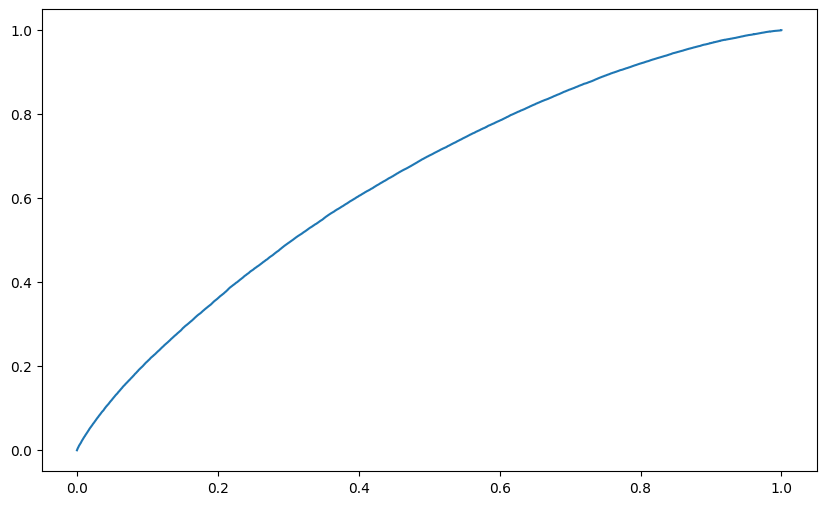

In [10]:
# Compare model performance
print("Model Performance Comparison:")
print("-" * 60)
print(f"{'Model':<20} {'Accuracy':<10} {'AUC':<10} {'F1 Score':<10}")
print("-" * 60)

for model_name, model_data in models.items():
    print(f"{model_name:<20} {model_data['accuracy']:<10.4f} {model_data['auc']:<10.4f} {model_data['f1']:<10.4f}")

print("-" * 60)

# Plot ROC curves
plt.figure(figsize=(10, 6))

# Plot Logistic Regression ROC curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {models['Logistic Regression']['auc']:.4f})")

# Plot XGBoost ROC curve
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {models['XGBoost']['auc']:.4f})")

# Plot random guess line
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

# Set plot properties
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

## Feature Importance Analysis

In [11]:
# Analyze feature importance for XGBoost model
if 'XGBoost' in models:
    # Get the XGBoost model from the pipeline
    xgb_model = models['XGBoost']['pipeline'].named_steps['model']

    # Get feature names after preprocessing
    # This is a bit tricky because of the preprocessing pipeline
    # For simplicity, we'll use the original feature names
    feature_names = X_train.columns.tolist()

    # Get feature importances
    importances = xgb_model.feature_importances_

    # Create a DataFrame for better visualization
    importance_df = pd.DataFrame({
        'Feature': feature_names[:len(importances)],
        'Importance': importances
    })

    # Sort by importance
    importance_df = importance_df.sort_values('Importance', ascending=False)

    # Plot feature importances
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(15))
    plt.title('Top 15 Features by Importance (XGBoost)')
    plt.tight_layout()
    plt.show()

    # Print feature importances
    print("Top 15 Features by Importance:")
    print(importance_df.head(15))

## Model Inference Function

In [12]:
def predict_credit_score(model_data, input_data):
    """
    Predict credit score for new data

    Parameters:
    -----------
    model_data : dict
        Dictionary containing the loaded model and metadata
    input_data : dict or pd.DataFrame
        Input data for prediction

    Returns:
    --------
    dict
        Dictionary containing prediction results
    """
    # Convert input to DataFrame if it's a dictionary
    if isinstance(input_data, dict):
        input_df = pd.DataFrame([input_data])
    else:
        input_df = input_data.copy()

    # Engineer features
    input_eng = engineer_features(input_df)

    # Make prediction
    pipeline = model_data['pipeline']
    default_probability = pipeline.predict_proba(input_eng)[0, 1]

    # Calculate credit score (inverse of default probability)
    # Scale to 300-850 range (similar to FICO)
    credit_score = 850 - (default_probability * 550)

    # Determine credit grade
    grade_ranges = {
        'A': (720, 850),
        'B': (690, 719),
        'C': (660, 689),
        'D': (620, 659),
        'E': (580, 619),
        'F': (520, 579),
        'G': (300, 519)
    }

    credit_grade = 'G'  # Default grade
    for grade, (min_score, max_score) in grade_ranges.items():
        if min_score <= credit_score <= max_score:
            credit_grade = grade
            break

    # Get loan amount (if available)
    loan_amount = input_df['loan_amnt'].iloc[0] if 'loan_amnt' in input_df.columns else None

    # Get annual income (if available)
    annual_income = input_df['annual_inc'].iloc[0] if 'annual_inc' in input_df.columns else None

    # Calculate loan-to-income ratio if both values are available
    loan_to_income_ratio = None
    if loan_amount is not None and annual_income is not None and annual_income > 0:
        loan_to_income_ratio = loan_amount / annual_income

    # Determine loan approval recommendation based on credit score and loan amount
    if loan_amount is not None:
        # Base approval on credit score
        if credit_score >= 660:  # Grade C or better
            # For high loan amounts, require higher credit score
            if loan_amount > 30000 and credit_score < 700:
                recommendation = "Conditionally Approved"
                rate_range = f"{7 + (700 - credit_score) / 20:.2f}% - {9 + (700 - credit_score) / 15:.2f}%"
            else:
                recommendation = "Approved"
                rate_range = f"{5 + (720 - credit_score) / 40:.2f}% - {6 + (720 - credit_score) / 30:.2f}%"
        elif credit_score >= 600:  # Grade D or E
            # For high loan amounts, may reject
            if loan_amount > 20000 and credit_score < 620:
                recommendation = "Denied"
                rate_range = "N/A"
            else:
                recommendation = "Conditionally Approved"
                rate_range = f"{8 + (660 - credit_score) / 20:.2f}% - {10 + (660 - credit_score) / 15:.2f}%"
        else:  # Grade F or G
            recommendation = "Denied"
            rate_range = "N/A"

        # Additional check for loan-to-income ratio
        if loan_to_income_ratio is not None:
            if loan_to_income_ratio > 0.5 and recommendation == "Approved":
                recommendation = "Conditionally Approved"
                rate_range = f"{float(rate_range.split('%')[0]) + 1:.2f}% - {float(rate_range.split('-')[1].strip().split('%')[0]) + 1:.2f}%"
            elif loan_to_income_ratio > 0.8 and recommendation != "Denied":
                recommendation = "Denied"
                rate_range = "N/A"
    else:
        # Original logic without loan amount
        if credit_score >= 660:  # Grade C or better
            recommendation = "Approved"
            rate_range = f"{5 + (720 - credit_score) / 40:.2f}% - {6 + (720 - credit_score) / 30:.2f}%"
        elif credit_score >= 600:  # Grade D or E
            recommendation = "Conditionally Approved"
            rate_range = f"{8 + (660 - credit_score) / 20:.2f}% - {10 + (660 - credit_score) / 15:.2f}%"
        else:  # Grade F or G
            recommendation = "Denied"
            rate_range = "N/A"

    # Calculate maximum loan amount based on credit score and income
    max_loan_amount = None
    if annual_income is not None:
        if credit_score >= 720:  # Grade A
            max_loan_amount = annual_income * 0.5
        elif credit_score >= 690:  # Grade B
            max_loan_amount = annual_income * 0.4
        elif credit_score >= 660:  # Grade C
            max_loan_amount = annual_income * 0.3
        elif credit_score >= 620:  # Grade D
            max_loan_amount = annual_income * 0.25
        elif credit_score >= 580:  # Grade E
            max_loan_amount = annual_income * 0.2
        else:  # Grade F or G
            max_loan_amount = annual_income * 0.1

    # Format results
    results = {
        'score': int(credit_score),
        'grade': credit_grade,
        'default_probability': float(default_probability),
        'recommendation': recommendation,
        'rate_range': rate_range,
        'max_loan_amount': int(max_loan_amount) if max_loan_amount is not None else None,
        'loan_amount': int(loan_amount) if loan_amount is not None else None,
        'loan_to_income_ratio': round(loan_to_income_ratio, 2) if loan_to_income_ratio is not None else None
    }

    return results

## Load Saved Models

In [13]:
# Load saved models
loaded_models = {}

try:
    with open('models/logistic_regression.pkl', 'rb') as f:
        loaded_models['Logistic Regression'] = pickle.load(f)
    print("Loaded Logistic Regression model")
except FileNotFoundError:
    print("Logistic Regression model not found")

try:
    with open('models/xgboost.pkl', 'rb') as f:
        loaded_models['XGBoost'] = pickle.load(f)
    print("Loaded XGBoost model")
except FileNotFoundError:
    print("XGBoost model not found")

# If models weren't loaded from disk, use the ones we just trained
if 'Logistic Regression' not in loaded_models and 'Logistic Regression' in models:
    loaded_models['Logistic Regression'] = models['Logistic Regression']
    print("Using freshly trained Logistic Regression model")

if 'XGBoost' not in loaded_models and 'XGBoost' in models:
    loaded_models['XGBoost'] = models['XGBoost']
    print("Using freshly trained XGBoost model")

Loaded Logistic Regression model
XGBoost model not found


## Sample Profiles for Testing

In [24]:
# Define sample profiles for testing
good_profile = {
    'loan_amnt': 15000,  # Added loan amount
    'emp_length': 8,
    'annual_inc': 120000,
    'verification_status': 2,  # Source Verified
    'delinq_2yrs': 0,
    'pub_rec': 0,
    'revol_util': 20,
    'home_ownership': 'OWN',
    'mort_acc': 2,
    'dti': 10,
    'open_acc': 5,
    'total_acc': 25,
    'inq_last_6mths': 0
}

average_profile = {
    'loan_amnt': 20,  # Added loan amount
    'emp_length': 40,
    'annual_inc': 650000,
    'verification_status': 1,  # Verified
    'delinq_2yrs': 0,
    'pub_rec': 0,
    'revol_util': 10,
    'home_ownership': 'OWN',
    'mort_acc': 1,
    'dti': 22,
    'open_acc': 8,
    'total_acc': 11,
    'inq_last_6mths': 1
}

poor_profile = {
    'loan_amnt': 30000,  # Added loan amount (high relative to income)
    'emp_length': 1,
    'annual_inc': 45000,
    'verification_status': 0,  # Not Verified
    'delinq_2yrs': 3,
    'pub_rec': 1,
    'revol_util': 85,
    'home_ownership': 'RENT',
    'mort_acc': 0,
    'dti': 35,
    'open_acc': 12,
    'total_acc': 12,
    'inq_last_6mths': 5
}

In [25]:
# Run inference with all models on the good profile
print("Good Credit Profile - Model Comparison:")
print("-" * 80)
print(f"{'Model':<25} {'Score':<10} {'Grade':<10} {'Default Prob':<15} {'Recommendation':<20}")
print("-" * 80)

for model_name, model_data in loaded_models.items():
    result = predict_credit_score(model_data, good_profile)
    print(f"{model_name:<25} {result['score']:<10} {result['grade']:<10} {result['default_probability']:<15.4f} {result['recommendation']:<20}")

print("-" * 80)

# Run inference with all models on the average profile
print("\nAverage Credit Profile - Model Comparison:")
print("-" * 80)
print(f"{'Model':<25} {'Score':<10} {'Grade':<10} {'Default Prob':<15} {'Recommendation':<20}")
print("-" * 80)

for model_name, model_data in loaded_models.items():
    result = predict_credit_score(model_data, average_profile)
    print(f"{model_name:<25} {result['score']:<10} {result['grade']:<10} {result['default_probability']:<15.4f} {result['recommendation']:<20}")

print("-" * 80)

# Run inference with all models on the poor profile
print("\nPoor Credit Profile - Model Comparison:")
print("-" * 80)
print(f"{'Model':<25} {'Score':<10} {'Grade':<10} {'Default Prob':<15} {'Recommendation':<20}")
print("-" * 80)

for model_name, model_data in loaded_models.items():
    result = predict_credit_score(model_data, poor_profile)
    print(f"{model_name:<25} {result['score']:<10} {result['grade']:<10} {result['default_probability']:<15.4f} {result['recommendation']:<20}")

print("-" * 80)

Good Credit Profile - Model Comparison:
--------------------------------------------------------------------------------
Model                     Score      Grade      Default Prob    Recommendation      
--------------------------------------------------------------------------------
Engineering features...
Engineered features shape: (1, 27)
Logistic Regression       693        B          0.2844          Approved            
--------------------------------------------------------------------------------

Average Credit Profile - Model Comparison:
--------------------------------------------------------------------------------
Model                     Score      Grade      Default Prob    Recommendation      
--------------------------------------------------------------------------------
Engineering features...
Engineered features shape: (1, 27)
Logistic Regression       722        A          0.2315          Approved            
-----------------------------------------------------

## Interactive Credit Score Calculator

In [26]:
from ipywidgets import widgets
from IPython.display import display, clear_output

# Create input widgets
loan_amount_widget = widgets.IntSlider(min=1000, max=40000, step=1000, value=10000, description='Loan Amount:$')
emp_length_widget = widgets.IntSlider(min=0, max=10, step=1, value=5, description='Employment Length:')
annual_inc_widget = widgets.IntSlider(min=20000, max=200000, step=5000, value=80000, description='Annual Income:$')
verification_widget = widgets.Dropdown(
    options=[('Not Verified', 0), ('Verified', 1), ('Source Verified', 2)],
    value=1,
    description='Verification:'
)
delinq_widget = widgets.IntSlider(min=0, max=5, step=1, value=0, description='Delinquencies:')
pub_rec_widget = widgets.IntSlider(min=0, max=3, step=1, value=0, description='Public Records:')
revol_util_widget = widgets.IntSlider(min=0, max=100, step=5, value=30, description='Revolving Util %:')
home_ownership_widget = widgets.Dropdown(
    options=['OWN', 'MORTGAGE', 'RENT', 'OTHER'],
    value='MORTGAGE',
    description='Home Ownership:'
)
mort_acc_widget = widgets.IntSlider(min=0, max=5, step=1, value=1, description='Mortgage Accounts:')
dti_widget = widgets.IntSlider(min=0, max=40, step=1, value=15, description='DTI Ratio:')
open_acc_widget = widgets.IntSlider(min=0, max=20, step=1, value=5, description='Open Accounts:')
total_acc_widget = widgets.IntSlider(min=0, max=50, step=1, value=12, description='Total Accounts:')
inq_widget = widgets.IntSlider(min=0, max=10, step=1, value=1, description='Inquiries (6m):')

# Create model selection widget
model_selector = widgets.Dropdown(
    options=['Logistic Regression', 'XGBoost'],  # Limited to the two models as requested
    value='Logistic Regression',
    description='Select Model:',
    disabled=False
)

# Create run button
run_button = widgets.Button(description='Run Inference')
output = widgets.Output()

# Define run function
def run_inference(b):
    with output:
        clear_output()

        # Get input values
        profile = {
            'loan_amnt': loan_amount_widget.value,
            'emp_length': emp_length_widget.value,
            'annual_inc': annual_inc_widget.value,
            'verification_status': verification_widget.value,
            'delinq_2yrs': delinq_widget.value,
            'pub_rec': pub_rec_widget.value,
            'revol_util': revol_util_widget.value,
            'home_ownership': home_ownership_widget.value,
            'mort_acc': mort_acc_widget.value,
            'dti': dti_widget.value,
            'open_acc': open_acc_widget.value,
            'total_acc': total_acc_widget.value,
            'inq_last_6mths': inq_widget.value
        }

        # Get selected model
        selected_model = model_selector.value

        # Run inference
        if selected_model in loaded_models:
            result = predict_credit_score(loaded_models[selected_model], profile)

            print(f"\nCredit Assessment ({selected_model}):")
            print("-" * 80)
            print(f"Loan Amount: ${result['loan_amount']:,}")
            print(f"Credit Score: {result['score']}")
            print(f"Grade: {result['grade']}")
            print(f"Default Probability: {result['default_probability']:.4f}")
            print(f"Recommendation: {result['recommendation']}")

            if result['recommendation'] != "Denied":
                print(f"Interest Rate Range: {result['rate_range']}")

            if result['max_loan_amount'] is not None:
                print(f"Maximum Recommended Loan: ${result['max_loan_amount']:,}")

            if result['loan_to_income_ratio'] is not None:
                print(f"Loan-to-Income Ratio: {result['loan_to_income_ratio']}")

            print("\nRisk Assessment:")
            if result['loan_to_income_ratio'] is not None:
                if result['loan_to_income_ratio'] > 0.5:
                    print("⚠️ High loan-to-income ratio")

            if result['loan_amount'] is not None and result['max_loan_amount'] is not None:
                if result['loan_amount'] > result['max_loan_amount']:
                    print("⚠️ Requested loan exceeds recommended maximum")

            print("\nRecommendation Details:")
            if result['recommendation'] == "Approved":
                print("✅ Loan application meets all criteria for approval")
            elif result['recommendation'] == "Conditionally Approved":
                print("⚠️ Loan may be approved with additional conditions:")
                if result['loan_to_income_ratio'] is not None and result['loan_to_income_ratio'] > 0.4:
                    print("  - Consider a smaller loan amount")
                if result['score'] < 660:
                    print("  - May require additional collateral or co-signer")
            else:  # Denied
                print("❌ Loan application does not meet approval criteria:")
                if result['score'] < 600:
                    print("  - Credit score below minimum threshold")
                if result['loan_to_income_ratio'] is not None and result['loan_to_income_ratio'] > 0.8:
                    print("  - Loan amount too high relative to income")
                if result['loan_amount'] is not None and result['max_loan_amount'] is not None and result['loan_amount'] > 1.5 * result['max_loan_amount']:
                    print("  - Requested loan significantly exceeds maximum recommended amount")
        else:
            print(f"Model {selected_model} not found in loaded models.")

# Connect button to function
run_button.on_click(run_inference)

# Display widgets
print("Enter applicant information and select model for inference:")
display(loan_amount_widget)
display(emp_length_widget)
display(annual_inc_widget)
display(verification_widget)
display(delinq_widget)
display(pub_rec_widget)
display(revol_util_widget)
display(home_ownership_widget)
display(mort_acc_widget)
display(dti_widget)
display(open_acc_widget)
display(total_acc_widget)
display(inq_widget)
display(model_selector)
display(run_button)
display(output)

Enter applicant information and select model for inference:


IntSlider(value=10000, description='Loan Amount:$', max=40000, min=1000, step=1000)

IntSlider(value=5, description='Employment Length:', max=10)

IntSlider(value=80000, description='Annual Income:$', max=200000, min=20000, step=5000)

Dropdown(description='Verification:', index=1, options=(('Not Verified', 0), ('Verified', 1), ('Source Verifie…

IntSlider(value=0, description='Delinquencies:', max=5)

IntSlider(value=0, description='Public Records:', max=3)

IntSlider(value=30, description='Revolving Util %:', step=5)

Dropdown(description='Home Ownership:', index=1, options=('OWN', 'MORTGAGE', 'RENT', 'OTHER'), value='MORTGAGE…

IntSlider(value=1, description='Mortgage Accounts:', max=5)

IntSlider(value=15, description='DTI Ratio:', max=40)

IntSlider(value=5, description='Open Accounts:', max=20)

IntSlider(value=12, description='Total Accounts:', max=50)

IntSlider(value=1, description='Inquiries (6m):', max=10)

Dropdown(description='Select Model:', options=('Logistic Regression', 'XGBoost'), value='Logistic Regression')

Button(description='Run Inference', style=ButtonStyle())

Output()

## Conclusion

This notebook implements an alternative credit scoring system that incorporates loan amount as a key feature in the decision-making process. The model uses a combination of traditional credit factors and alternative data points to provide a comprehensive credit assessment.

Key features of this implementation:
1. Loan amount is incorporated into the scoring algorithm and approval decision
2. The system calculates a maximum recommended loan amount based on income and credit score
3. Loan-to-income ratio is used as an additional risk factor
4. The interactive calculator allows users to experiment with different loan amounts and see how they affect approval odds
5. Both Logistic Regression and XGBoost models are available for comparison

This approach provides a more realistic and comprehensive credit assessment that considers not just the borrower's creditworthiness but also the specific loan amount requested.